### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.neighbors import KNeighborsClassifier
import pvlib
from scipy.stats import ks_2samp
from sklearn.metrics import root_mean_squared_error
from kgcpy import *
from sklearn.impute import KNNImputer
from pvlib.location import Location
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import re
from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

### Defining the variables for the script inputs

In [2]:
lat_deg = 45.5028249
lon_deg = 9.1561092
altitude = 120

shape1 = 8760
shape2 = 525600
days = 365
points_per_day = 24
mins_per_day = 1440

# Initialize the TimezoneFinder
tf = TimezoneFinder()
latitude = lat_deg
longitude = lon_deg
# Get the timezone name
timezone_str = tf.timezone_at(lng=longitude, lat=latitude)
tz = timezone_str
#tz='Etc/GMT+2'
start = pd.Timestamp('2017-01-01 00:00:00', tz=tz)  # Start time
end = pd.Timestamp('2017-12-31 23:59:00', tz=tz)  # End time

In [3]:
lat = lat_deg
lon = lon_deg

# Look up the Köppen-Geiger climate zone
kg_zone = lookupCZ(lat, lon)
kg_zone

'Cfa'

In [4]:
lat = lat_deg
lon = lon_deg
# Look up the Köppen-Geiger climate zone
kg_zone = lookupCZ(lat, lon)
#kg_zone

# Determine the result based on the first letter of kg_zone
first_letter = kg_zone

if first_letter == 'Af':
    result = 'Aw'
elif first_letter == 'Am':
    result = 'Aw'
elif first_letter == 'As':
    result = 'Aw'
elif first_letter == 'Aw':
    result = 'Aw'
elif first_letter == 'BSh':
    result = 'BSh'
elif first_letter == 'BSk':
    result = 'BSk'
elif first_letter == 'BWh':
    result = 'BWh'
elif first_letter == 'BWk':
    result = 'BWh'
elif first_letter == 'Cfa':
    result = 'Cfa'
elif first_letter == 'Cfb':
    result = 'Cfb'
elif first_letter == 'Cfc':
    result = 'Cfb'
elif first_letter == 'Csa':
    result = 'Csa'
elif first_letter == 'Csb':
    result = 'Csb'
elif first_letter == 'Csc':
    result = 'Csb'
elif first_letter in ('Cwa', 'Cwb', 'Cwc'):
    result = 'Csa'
elif first_letter in ('Dfa', 'Dfb', 'Dfc', 'Dfd', 'Dsa', 'Dsb', 'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd'):
    result = 'Csa'
elif first_letter in ('EF', 'ET'):
    result = 'Csa'
else:
    result = 'Cfb'  # Fallback in case of an unexpected value
print("Climate zone:", kg_zone)
result

Climate zone: Cfa


'Cfa'

### Importing measured hourly DNI and GHI

In [5]:
hourly_irrad_m = np.genfromtxt(r'hourly_irrad_m_modified_new.csv',delimiter=',') #importing hourly timeseries- should be 8760 items for one year, the columns are day (1-365), hour (1-24), GHI (W/m2), DNI (W/m2)
hourly_irrad_m

array([[  1.,   1.,   0.],
       [  1.,   2.,   0.],
       [  1.,   3.,   0.],
       ...,
       [365.,  22.,   0.],
       [365.,  23.,   0.],
       [365.,  24.,   0.]])

### Importing training data for specified climate zones at hourly and minute resolution

In [6]:
hourly_database_ghi = np.genfromtxt(f'C:/Users/o.omoyele/Desktop/Australia/ND_Model_Mean_QC/{result}/input_knn.csv',delimiter=',') 
#this gets the climate data for KG climate classification zones --currently its about 14 years of data
minutal_database_ghi = np.genfromtxt(f'C:/Users/o.omoyele/Desktop/Australia/ND_Model_Mean_QC/{result}/minutal_new.csv',delimiter=',') 
#this is the same data at a minutal resolution -- has dimensionless/clearsky GHI and DNI in there. Number of steps are 1000 which need to be confirmed. -- need to be confirmed from prof. if it is dimensionless GHI & DNI or clearsky GHI & DNI

### Training the data

In [7]:
neigh_ghi = KNeighborsClassifier(n_neighbors=1)
neigh_ghi.fit(hourly_database_ghi[:,[1,2,3,4,5]],hourly_database_ghi[:,0]) #training the KNN classifier using the inputs as columns 1, 2, 3, and 4 and the labels from column 0 as the target variable for classification

KNeighborsClassifier(n_neighbors=1)

### Importing clear sky DNI and GHI using McClear at hourly and minutal resolution -- PVLib API call for CAMS McClear

In [8]:
#for DNI
##hourly clear sky dni
hourly_cs, metadata = pvlib.iotools.get_cams(latitude=lat_deg, 
                       longitude=lon_deg, 
                       start=start, 
                       end=end, 
                       email='jacola.omoyele@gmail.com', 
                       identifier='mcclear', 
                       altitude=altitude, 
                       time_step='1h', 
                       time_ref='TST', 
                       verbose=False, 
                       integrated=False, 
                       label=None, 
                       map_variables=True, 
                       server='api.soda-solardata.com', 
                       timeout=600)

hourly_irrad_cs_dni = hourly_cs[['dni_clear']].reset_index(drop=True)
hourly_irrad_cs_dni = hourly_irrad_cs_dni.to_numpy().reshape(shape1)
hourly_irrad_cs_ghi = hourly_cs[['ghi_extra']].reset_index(drop=True)
hourly_irrad_cs_ghi = hourly_irrad_cs_ghi.to_numpy().reshape(shape1)

#minutal clear sky dni
minutal_cs, metadata = pvlib.iotools.get_cams(latitude=lat_deg, 
                       longitude=lon_deg, 
                       start=start, 
                       end=end, 
                       email='jacola.omoyele@gmail.com', 
                       identifier='mcclear', 
                       altitude=altitude, 
                       time_step='1min', 
                       time_ref='TST', 
                       verbose=False, 
                       integrated=False, 
                       label=None, 
                       map_variables=True, 
                       server='api.soda-solardata.com', 
                       timeout=600)

min_irrad_cs_dni = minutal_cs[['dni_clear']].reset_index(drop=True)
min_irrad_cs_dni = min_irrad_cs_dni.to_numpy().reshape(shape2)
min_irrad_cs_ghi = minutal_cs[['ghi_extra']].reset_index(drop=True)
min_irrad_cs_ghi = min_irrad_cs_ghi.to_numpy().reshape(shape2)

min_irrad_cs_ghi_extra = minutal_cs[['ghi_extra']].reset_index(drop=True)
min_irrad_cs_ghi_extra = min_irrad_cs_ghi_extra.to_numpy().reshape(shape2)

### Getting solar Altitude angle (alpha) and Hour angle (omega) in degrees as these will be needed to create masks --calling PVlib function

In [9]:
#tz='Etc/GMT'
#start1 = pd.Timestamp('2017-01-01 00:00:00')  # Start time
#end1 = pd.Timestamp('2017-12-31 23:59:00')  # End time

date_range = pd.date_range(start=start, end=end, freq="1h")
solar_position = pvlib.solarposition.get_solarposition(
    date_range, latitude = lat_deg, longitude = lon_deg, altitude=altitude, pressure=1013.25
)

alpha_deg = solar_position['elevation'].values
EOT = solar_position['equation_of_time'].values #in minutes

omega_deg = pvlib.solarposition.hour_angle(date_range, longitude=lon_deg, equation_of_time = EOT)

### Creating Masks to set negative altitude angles irradiation to 0 and to get a Before-Noon Mask for Morning Fraction Fm

In [10]:
#creating mask for when the altitude angle is less than 0 (or is negative)
neg_alpha_deg_mask = (alpha_deg <= 0) #boolean mask that keeps negative altitude angles (in degrees)

#creating a 2d (daily) array of the mask
neg_alpha_deg_mask_2d = np.copy(neg_alpha_deg_mask)
neg_alpha_deg_mask_2d.shape = (days,points_per_day) #transformation of array to 2D from 1D

#for before-noon mask for morning fraction
before_noon_mask = (omega_deg<0) #boolean mask for before-noon solar hour angles in radians

### Converting the measured and clear sky DNI to 2d (daily) for calculation of Clear Sky Index or dimensionless irradiance

In [11]:
hourly_irrad_cs_ghi_2d = np.copy(hourly_irrad_cs_ghi)
hourly_irrad_cs_ghi_2d.shape = (days,points_per_day)
hourly_irrad_cs_ghi_2d[neg_alpha_deg_mask_2d] = 0 #masked to 0 using negative altitude angles mask

hourly_irrad_m_ghi_2d = np.copy(hourly_irrad_m[:,2])
hourly_irrad_m_ghi_2d.shape = (days,points_per_day)
hourly_irrad_m_ghi_2d[neg_alpha_deg_mask_2d] = 0 #masked to 0 using negative altitude angles mask

### Calculation of the daily Clear Sky Index or Dimensionless Irradiance or Direct Fraction Kb for DNI

In [12]:
#Kb = hourly_irrad_m_dni_2d.sum(1) / hourly_irrad_cs_dni_2d.sum(1) #calculation for the daily direct fraction index Kb by summing along axis 1 (columns) and then dividing the sums element wise
Kt = hourly_irrad_m_ghi_2d.mean(1) / hourly_irrad_cs_ghi_2d.mean(1) #calculation for the daily direct fraction index Kt by summing along axis 1 (columns) and then dividing the sums element wise

days = 365
#points_per_day = 1440  # since there are 1440 minutes in a day (525600 / 365)
day_points = 24

data_A = hourly_cs['ghi_extra'].values.reshape((days, day_points))
#data_A
data_B = hourly_irrad_m[:,2].reshape((days, day_points))
#data_B

data_A1 = pd.DataFrame(data_A)
data_B1 = pd.DataFrame(data_B)

Kt_new = data_B1.mean(1) / data_A1.mean(1)

### Calculation of the Variability Index VI

In [13]:
neg_alpha_deg_mask_2d_k = np.delete(neg_alpha_deg_mask_2d,0,1) #deletes the first column from the 2D matrix


hourly_irrad_cs_ghi_2d_k = np.delete(hourly_irrad_cs_ghi_2d,0,1) #deletes the first column from the clear sky irradiance array
hourly_irrad_cs_ghi_2d_k[neg_alpha_deg_mask_2d_k] = 0 #masks using the newly transformed arrays

hourly_irrad_cs_ghi_2d_k_less1 = np.delete(hourly_irrad_cs_ghi_2d,23,1) #creates a new clear sky irradiance array with one less interval (n-1)
hourly_irrad_cs_ghi_2d_k_less1[neg_alpha_deg_mask_2d_k] = 0 #masks using the newly transformed arrays
 
hourly_irrad_m_ghi_2d_k = np.delete(hourly_irrad_m_ghi_2d,0,1) #deletes the first column from the measured irradiance array
hourly_irrad_m_ghi_2d_k[neg_alpha_deg_mask_2d_k] = 0 #masks using the newly transformed arrays

hourly_irrad_m_ghi_2d_k_less1 = np.delete(hourly_irrad_m_ghi_2d,23,1) #creates a new measured irradiance array with one less interval (n-1)
hourly_irrad_m_ghi_2d_k_less1[neg_alpha_deg_mask_2d_k] = 0 #masks using the newly transformed arrays

numerator_ghi = (np.power( np.power(hourly_irrad_m_ghi_2d_k-hourly_irrad_m_ghi_2d_k_less1,2) + 1 , 1/2 )).sum(1) #numerator of VI (see Larraneta et al., 2017)
denominator_ghi = (np.power( np.power(hourly_irrad_cs_ghi_2d_k-hourly_irrad_cs_ghi_2d_k_less1,2) + 1 , 1/2 )).sum(1) #denominator of VI (see Larraneta et al., 2017)
variability_index_ghi = numerator_ghi/denominator_ghi

In [14]:
days = 365
#points_per_day = 1440  # since there are 1440 minutes in a day (525600 / 365)
day_points = 24
# Convert series to dataframes and reshape

data_A = hourly_cs['ghi_extra'].values.reshape((days, day_points))
#data_A
data_B = hourly_irrad_m[:,2].reshape((days, day_points))
#data_B

data_A1 = pd.DataFrame(data_A).transpose()
data_B1 = pd.DataFrame(data_B).transpose()
data_A1 = data_A1.values
data_B1 = data_B1.values

data_C1 = np.sort(data_B, axis=1)[:, ::-1]
data_C1 = pd.DataFrame(data_C1)
data_C1 = data_C1.transpose().values


#data_A1
a_values = np.zeros(data_A1.shape[1])
# Loop over each column
for i in range(data_A1.shape[1]):
    # Calculate daily differences for the current column
    daily_differences_a_values = np.diff(data_A1[:, i])
    
    # Compute the value of a for the current column
    a_values[i] = np.power(np.power(daily_differences_a_values, 2) + 1, 1/2).sum()
irradiance_cs = pd.DataFrame({'days': a_values})
#irradiance_cs

b_values = np.zeros(data_B1.shape[1])
# Loop over each column
for i in range(data_B1.shape[1]):
    # Calculate daily differences for the current column
    daily_differences_b_values = np.diff(data_B1[:, i])
    
    # Compute the value of a for the current column
    b_values[i] = np.power(np.power(daily_differences_b_values, 2) + 1, 1/2).sum()

irradiance = pd.DataFrame({'days': b_values})
#irradiance

c_values = np.zeros(data_C1.shape[1])
# Loop over each column
for i in range(data_C1.shape[1]):
    # Calculate daily differences for the current column
    daily_differences_c_values = np.diff(data_C1[:, i])
    
    # Compute the value of a for the current column
    c_values[i] = np.power(np.power(daily_differences_c_values, 2) + 1, 1/2).sum()

irradiance_norm = pd.DataFrame({'days': c_values})
#irradiance

VI1 = irradiance['days'] / irradiance_cs['days']
NVI1 = irradiance['days'] / irradiance_norm['days']

### Calculation of the Morning Fraction Fm

In [15]:
after_noon_mask = np.logical_not(before_noon_mask) #mask for afternoon - opposite of before noon mask
after_noon_mask_2d = np.copy(after_noon_mask) #new copy for 2D transformation
after_noon_mask_2d.shape = (days,points_per_day) #2D transformation


hourly_irrad_m_after_noon_ghi_2d = np.copy(hourly_irrad_m_ghi_2d) #copy of measured irradiance array
hourly_irrad_m_after_noon_ghi_2d[after_noon_mask_2d] = 0 #setting afternoon values to 0 - this is done as morning fraction is the ratio of the sum of the irradiance in the first half with the whole day

Fm_ghi = hourly_irrad_m_after_noon_ghi_2d.sum(1) / hourly_irrad_m_ghi_2d.sum(1) #sum along the second axis and dividing element-wise for Fm
Fm_ghi = np.nan_to_num(Fm_ghi) #if division leads to NaN, replace with 0

In [16]:
data = hourly_irrad_m[:,2]

# Initialize a list to store normalized IC-CDF values for each day
normalized_ic_cdf_values = []

# Loop through each day and compute the normalized IC-CDF
for day in range(days):
    # Step 1: Extract hourly data for the current day
    daily_data = data[day * points_per_day:(day + 1) * points_per_day]

    # Step 2: Compute the time-differenced series (hourly changes)
    differenced_data = np.diff(daily_data)

    # Step 3: Sort the differenced data and compute the empirical CDF
    sorted_diff = np.sort(differenced_data)
    n = len(sorted_diff)
    cdf = np.arange(1, n + 1) / n

    # Step 4: Calculate the Complementary CDF (CCDF)
    ccdf = 1 - cdf

    # Step 5: Compute the IC-CDF using the trapezoidal rule
    ic_cdf = np.trapezoid(ccdf, sorted_diff)

    # Step 6: Normalize the IC-CDF by dividing by the range of the differenced data
    diff_range = sorted_diff.max() - sorted_diff.min()
    if diff_range != 0:  # Avoid division by zero
        normalized_ic_cdf = ic_cdf / diff_range
    else:
        normalized_ic_cdf = 0  # If range is zero, set normalized IC-CDF to 0

    # Store the normalized IC-CDF value
    normalized_ic_cdf_values.append(normalized_ic_cdf)

In [17]:
daily_means = []

for day in range(days):
    # Step 1: Extract hourly data for the current day
    daily_data = data[day * points_per_day:(day + 1) * points_per_day]

    # Step 2: Compute the mean of the daily data
    daily_mean = np.mean(daily_data)

    # Store the daily mean
    daily_means.append(daily_mean)

### Packaging the obtained daily indicators

In [18]:
calculated_indicators_ghi = np.zeros((days,5))
calculated_indicators_ghi[:,0] = Kt_new
calculated_indicators_ghi[:,1] = VI1
calculated_indicators_ghi[:,2] = Fm_ghi
calculated_indicators_ghi[:,3] = NVI1
calculated_indicators_ghi[:,4] = normalized_ic_cdf_values
#calculated_indicators_ghi[:,5] = daily_means

### Predicting Similar Days

In [19]:
similar_days_ghi = neigh_ghi.predict(calculated_indicators_ghi) #predicting the class labels for similar days from calculated indices (only Kb, and VI here for now)
similar_days_ghi.shape

(365,)

### Getting the altitude or elevation angles (alpha) in minute resolution - calling PVlib function

In [20]:
date_range = pd.date_range(start=start, end=end, freq="1min")
date_range_utc = date_range.tz_convert('UTC')
solar_position = pvlib.solarposition.get_solarposition(
    date_range_utc, latitude = lat_deg, longitude = lon_deg, altitude=altitude, pressure=1013.25
)

alpha_deg_min = solar_position['elevation'].values

### Getting the needed mask - positive alpha in degrees in 2D

In [21]:
pos_alpha_deg_mask_min = (alpha_deg_min > 0) #masking for positive altitude angles
pos_alpha_deg_min = np.maximum(alpha_deg_min,0) #keeping maxima of either altitude angles or 0 to exclude negatives

pos_alpha_deg_mask_min_2d = np.copy(pos_alpha_deg_mask_min) 
pos_alpha_deg_mask_min_2d.shape = (days,24*60) #reshaping for minutes

### Upscaling now to minutal resolution for Kb and Kt

In [22]:
min_syn_kb = []
min_syn_kt = []
syn_day = np.zeros((24*60,2)) #new array with daily data at minutal resolution represented by zeros

for i in range(0,days): #iterating for the year across each day
  ups_day_ghi = minutal_database_ghi[np.where(minutal_database_ghi[:,0] == similar_days_ghi[i])] #gets the data from minutal dataset for each similar day -- in other words, get 1000 rows for each similar day
  indices = np.around(1000 * np.arange(1,np.sum(pos_alpha_deg_mask_min_2d[i])+1)/np.sum(pos_alpha_deg_mask_min_2d[i])) #here we generate indices to later sample the ups_day data -- the indices generated are generated as a fraction of the total time the sum is up and is therefore then multiplied by 1000 to scale it up
  syn_day[pos_alpha_deg_mask_min_2d[i]] = ups_day_ghi[indices.astype(int)-1][:,1:3] #fills the synthetic day data with the sampled values from the ups_day for each of the created indices (as integer) in each similar day -- so for each similar day, only those rows of the 1000 rows are picked for Kb and Kt which are indexed using indices
  min_syn_kt = np.append(min_syn_kt, syn_day[:,1]) #appends the synthetic solar irradiance data for the day to the min_syn_kt array

#print(ups_day_dni.shape)
print(ups_day_ghi.shape)

(1000, 2)


### Producing DNI and GHI now from synthetic minutal data

In [23]:
hourly_irrad_m_new = pd.DataFrame(data_B).sum(1)
syn_min_ghi_test = (min_syn_kt * min_irrad_cs_ghi ).reshape(days, mins_per_day)
#syn_min_ghi_test = pd.DataFrame(syn_min_ghi_test)
syn_min_ghi_test = pd.DataFrame(syn_min_ghi_test).sum(1)/60


# Function to minimize for each day
def objective(k, i):
    percentage_change = (hourly_irrad_m_new[i] - (k * syn_min_ghi_test[i]))/hourly_irrad_m_new[i]
    return np.abs(percentage_change)

# Array to store optimal k values
optimal_k = np.zeros(days)

# Optimize k for each day
for i in range(days):
    result = minimize(objective, x0=0, args=(i,), bounds=[(0, 10)])
    optimal_k[i] = result.x[0]

#print("Optimal k values for each day:", optimal_k)


A = (min_syn_kt * min_irrad_cs_ghi ).reshape(days, mins_per_day)
#A = pd.DataFrame(A)
B = A * optimal_k [:, np.newaxis]
B = pd.DataFrame(B)

df = pd.melt(B.transpose())

df = df.rename(columns={'value':'ghi'})
df.describe()

,variable,ghi
count,525600.000000,525600.000000
mean,182.000000,167.569882
std,105.366129,263.084967
min,0.000000,0.000000
25%,91.000000,0.000000
50%,182.000000,0.000000
75%,273.000000,261.090584
max,364.000000,1413.503834


### Exporting the synthetic minutal timeseries

In [24]:
#np.savetxt('synthetic_dni.csv', syn_min_dni, delimiter=',')
#np.savetxt('synthetic_ghi.csv', syn_min_ghi, delimiter=',')

### Plotting the GHI

C:\Users\o.omoyele\Desktop\Ola\tsam\myENV\NDENV\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


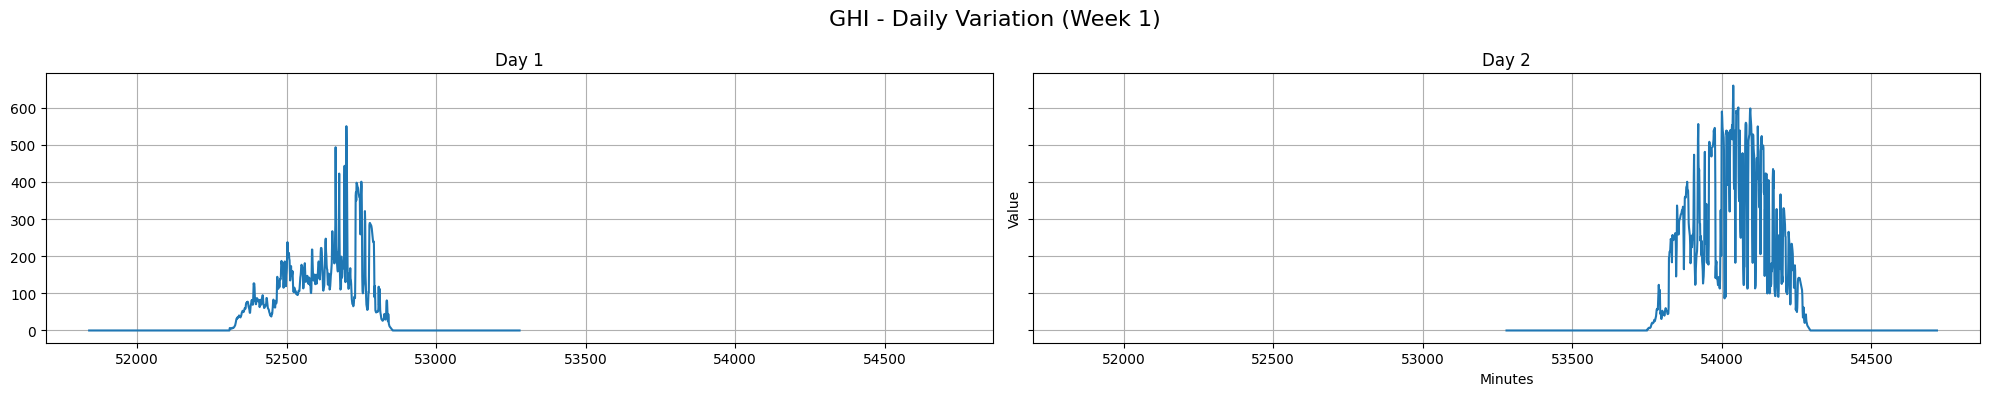

In [25]:
# Split the array into chunks of 1440
daily_chunks = np.array_split(df['ghi'], days)  # 365 days in a year

# Create subplots for the first week (7 days)
fig, axs = plt.subplots(1, 2, figsize=(20, 4), sharex=True, sharey=True)

# Customize subplot appearance
fig.suptitle("GHI - Daily Variation (Week 1)", fontsize=16)
plt.xlabel("Minutes")
plt.ylabel("Value")

# Populate subplots with data for the first week
for day, chunk in enumerate(daily_chunks[36:38]):
    axs[day].plot(chunk, label=f"Day {day + 1}")
    axs[day].set_title(f"Day {day + 1}")
    axs[day].grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot for the first week
plt.show()


### Plotting the synthetic and measured minutal timeseries to compare

In [26]:
data = pd.read_csv(r'Milan2017_new.csv')

In [27]:
data.describe()

,Unnamed: 0,ghi
count,525600.000000,525600.000000
mean,262799.500000,167.569883
std,151727.795081,260.861716
min,0.000000,0.000000
25%,131399.750000,0.000000
50%,262799.500000,4.000000
75%,394199.250000,265.000000
max,525599.000000,1312.000000


### Validation - Performing KS Integral Test

In [28]:
# for DNI
# Perform the KSI test between the measured and synthetic distribution
statistic, p_value = ks_2samp(data['ghi'], df['ghi'])

# Output the results
print("###################################################################################################")
print("Synthetic DNI")
print("###################################################################################################")
print("Kolmogorov-Smirnov Test Results:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The null hypothesis cannot be rejected. The samples may be drawn from the same distribution.")
else:
    print("The null hypothesis is rejected. The samples are likely drawn from different distributions.")

# for KSI in %
    
vc = 1.63/(len(data)**(1/2))
a_critical = vc*(data['ghi'].max()-data['ghi'].min())
ksi_percentage = statistic/a_critical*100

print('KSI as percentage is', round(ksi_percentage,2),'%')

'''
# Perform the KSI test between the measured and Larraneta's distribution
statistic, p_value = ks_2samp(Larranetas_dni, measured_dni)

# Output the results
print("###################################################################################################")
print("Larraneta's DNI")
print("###################################################################################################")
print("Kolmogorov-Smirnov Test Results:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The null hypothesis cannot be rejected. The samples may be drawn from the same distribution.")
else:
    print("The null hypothesis is rejected. The samples are likely drawn from different distributions.")

# for KSI in %
    
vc = 1.63/(len(measured_dni)**(1/2))
a_critical = vc*(measured_dni.max()-measured_dni.min())
ksi_percentage = statistic/a_critical*100

print('KSI as percentage is', round(ksi_percentage,2),'%')
'''

###################################################################################################
Synthetic DNI
###################################################################################################
Kolmogorov-Smirnov Test Results:
Statistic: 0.05038812785388125
p-value: 0.0
The null hypothesis is rejected. The samples are likely drawn from different distributions.
KSI as percentage is 1.71 %


'\n# Perform the KSI test between the measured and Larraneta\'s distribution\nstatistic, p_value = ks_2samp(Larranetas_dni, measured_dni)\n\n# Output the results\nprint("###################################################################################################")\nprint("Larraneta\'s DNI")\nprint("###################################################################################################")\nprint("Kolmogorov-Smirnov Test Results:")\nprint("Statistic:", statistic)\nprint("p-value:", p_value)\n\n# Interpret the results\nalpha = 0.05  # Significance level\nif p_value > alpha:\n    print("The null hypothesis cannot be rejected. The samples may be drawn from the same distribution.")\nelse:\n    print("The null hypothesis is rejected. The samples are likely drawn from different distributions.")\n\n# for KSI in %\n    \nvc = 1.63/(len(measured_dni)**(1/2))\na_critical = vc*(measured_dni.max()-measured_dni.min())\nksi_percentage = statistic/a_critical*100\n\nprint(\'KSI as perc

### Getting RMSE and NRMSE

In [29]:
# for dni
# for synthetic dni

rms = root_mean_squared_error(data['ghi'], df['ghi'])
nrmse = round(rms/(data['ghi'].max() - data['ghi'].min())*100,2)
print("###############################################################################")
print("Synthetic GHI")
print("###############################################################################")
print('RMSE is:', round(rms,2))
print('NRMSE is:', nrmse,'%')

# for Larraneta's dni
'''
rms = root_mean_squared_error(measured_dni, Larranetas_dni)
nrmse = round(rms/(measured_dni.max() - measured_dni.min())*100,2)
print("###############################################################################")
print("Larraneta's DNI")
print("###############################################################################")
print('RMSE is:', round(rms,2))
print('NRMSE is:', nrmse,'%')
'''

###############################################################################
Synthetic GHI
###############################################################################
RMSE is: 110.48
NRMSE is: 8.42 %


'\nrms = root_mean_squared_error(measured_dni, Larranetas_dni)\nnrmse = round(rms/(measured_dni.max() - measured_dni.min())*100,2)\nprint("###############################################################################")\nprint("Larraneta\'s DNI")\nprint("###############################################################################")\nprint(\'RMSE is:\', round(rms,2))\nprint(\'NRMSE is:\', nrmse,\'%\')\n'

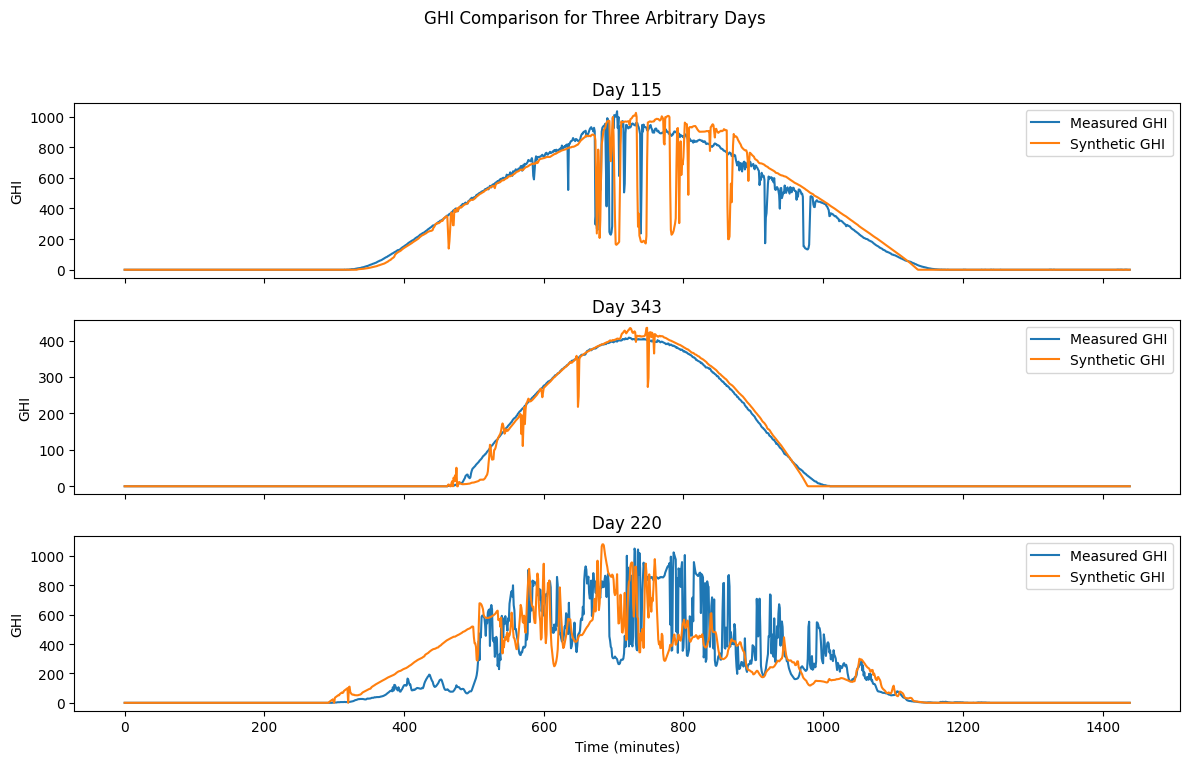

In [30]:
# Extract the GHI columns
ghi_measured = data['ghi'].values
ghi_synthetic = df['ghi'].values

# Reshape the data into 365 days, each with 1440 minutes
ghi_measured_reshaped = ghi_measured.reshape(days, mins_per_day)
ghi_synthetic_reshaped = ghi_synthetic.reshape(days, mins_per_day)

# Choose three arbitrary days to plot (e.g., day 50, day 100, day 150)
days_to_plot = [114, 342, 219]

# Create a plot with three vertical subplots
fig, axs = plt.subplots(len(days_to_plot), 1, figsize=(12, 8), sharex=True)

for i, day in enumerate(days_to_plot):
    axs[i].plot(ghi_measured_reshaped[day], label='Measured GHI')
    axs[i].plot(ghi_synthetic_reshaped[day], label='Synthetic GHI')
    axs[i].set_title(f'Day {day + 1}')
    axs[i].set_ylabel('GHI')
    axs[i].legend()

# Set common labels
plt.xlabel('Time (minutes)')
plt.suptitle('GHI Comparison for Three Arbitrary Days')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('Milan_location.png')
plt.show()

In [31]:
data

,Unnamed: 0,date,ghi
0,0,2017-01-01 00:00:00,0.0
1,1,2017-01-01 00:01:00,0.0
2,2,2017-01-01 00:02:00,0.0
3,3,2017-01-01 00:03:00,0.0
4,4,2017-01-01 00:04:00,0.0
...,...,...,...
525595,525595,2017-12-31 23:55:00,0.0
525596,525596,2017-12-31 23:56:00,0.0
525597,525597,2017-12-31 23:57:00,0.0
525598,525598,2017-12-31 23:58:00,0.0


In [32]:
df['GHI'] = data['ghi']

In [33]:
date_range = pd.date_range(start='01-01-2017 00:00', end='31-12-2017 23:59', freq='min')
df['date']= pd.DataFrame(date_range)

In [34]:
df.set_index('date', inplace=True)
df

,variable,ghi,GHI
date,,,
2017-01-01 00:00:00,0,0.0,0.0
2017-01-01 00:01:00,0,0.0,0.0
2017-01-01 00:02:00,0,0.0,0.0
2017-01-01 00:03:00,0,0.0,0.0
2017-01-01 00:04:00,0,0.0,0.0
...,...,...,...
2017-12-31 23:55:00,364,0.0,0.0
2017-12-31 23:56:00,364,0.0,0.0
2017-12-31 23:57:00,364,0.0,0.0


In [35]:
df_hourly = df.resample('h').mean()

In [36]:
# for DNI
# Perform the KSI test between the measured and synthetic distribution
statistic, p_value = ks_2samp(df_hourly['GHI'], df_hourly['ghi'])

# Output the results
print("###################################################################################################")
print("Synthetic DNI")
print("###################################################################################################")
print("Kolmogorov-Smirnov Test Results:")
print("Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The null hypothesis cannot be rejected. The samples may be drawn from the same distribution.")
else:
    print("The null hypothesis is rejected. The samples are likely drawn from different distributions.")

# for KSI in %
    
vc = 1.63/(len(df_hourly)**(1/2))
a_critical = vc*(df_hourly['GHI'].max()-df_hourly['GHI'].min())
ksi_percentage = statistic/a_critical*100

print('KSI as percentage is', round(ksi_percentage,2),'%')

###################################################################################################
Synthetic DNI
###################################################################################################
Kolmogorov-Smirnov Test Results:
Statistic: 0.13207762557077626
p-value: 5.550631059710832e-67
The null hypothesis is rejected. The samples are likely drawn from different distributions.
KSI as percentage is 0.74 %


In [37]:
# for dni
# for synthetic dni

rms = root_mean_squared_error(df_hourly['GHI'], df_hourly['ghi'])
nrmse = round(rms/(df_hourly['GHI'].max() - df_hourly['GHI'].min())*100,2)
print("###############################################################################")
print("Synthetic GHI")
print("###############################################################################")
print('RMSE is:', round(rms,2))
print('NRMSE is:', nrmse,'%')

###############################################################################
Synthetic GHI
###############################################################################
RMSE is: 70.54
NRMSE is: 6.93 %


In [38]:
# Define a function to calculate NRMSE using range for each day
def calculate_nrmse(group):
    ghi = group['ghi']
    GHI = group['GHI']
    rmse = np.sqrt(np.mean((GHI - ghi) ** 2))
    ghi_range = GHI.max() - GHI.min()
    nrmse = rmse / ghi_range if ghi_range != 0 else np.nan  # Avoid division by zero
    return nrmse

# Group the data by day and calculate the daily NRMSE
daily_nrmse = df.groupby(df.index.date).apply(calculate_nrmse)

# Convert the result to a DataFrame for easy viewing
daily_nrmse_df = daily_nrmse.reset_index(name='NRMSE')
daily_nrmse_df.columns = ['Date', 'NRMSE']

# Get the rows with the three smallest NRMSE values
three_smallest = daily_nrmse_df.nsmallest(9, 'NRMSE')

# Get the rows with the three largest NRMSE values
three_largest = daily_nrmse_df.nlargest(9, 'NRMSE')

# Display the results
print("Three Smallest NRMSE Values:")
print(three_smallest)

print("\nThree Largest NRMSE Values:")
print(three_largest)

Three Smallest NRMSE Values:
           Date     NRMSE
295  2017-10-23  0.019738
0    2017-01-01  0.026694
342  2017-12-09  0.031268
336  2017-12-03  0.032515
290  2017-10-18  0.032699
8    2017-01-09  0.032765
321  2017-11-18  0.033336
25   2017-01-26  0.034559
288  2017-10-16  0.035306

Three Largest NRMSE Values:
           Date     NRMSE
126  2017-05-07  0.256522
190  2017-07-10  0.251191
204  2017-07-24  0.249434
30   2017-01-31  0.241128
107  2017-04-18  0.235015
171  2017-06-21  0.233199
165  2017-06-15  0.222230
127  2017-05-08  0.220818
222  2017-08-11  0.218620


In [39]:
daily_nrmse_df.to_csv('daily_nrmse_df.csv')

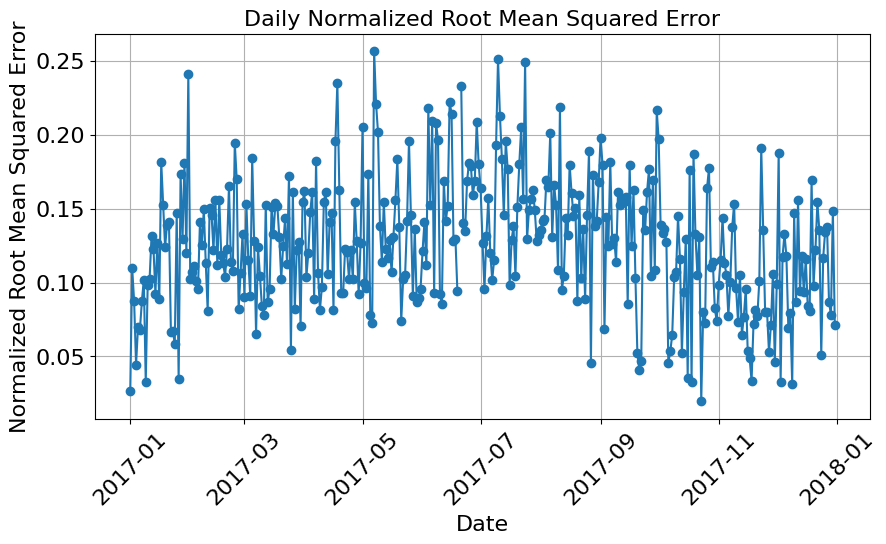

In [40]:
fontsize=16

plt.figure(figsize=(10, 5))
plt.plot(daily_nrmse_df['Date'], daily_nrmse_df['NRMSE'], marker='o', linestyle='-')
plt.xlabel('Date', fontsize=fontsize)
plt.ylabel('Normalized Root Mean Squared Error', fontsize=fontsize)
plt.title('Daily Normalized Root Mean Squared Error', fontsize=fontsize)
plt.xticks(rotation=45, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()
plt.savefig('daily_nrmse_df.png', bbox_inches='tight')

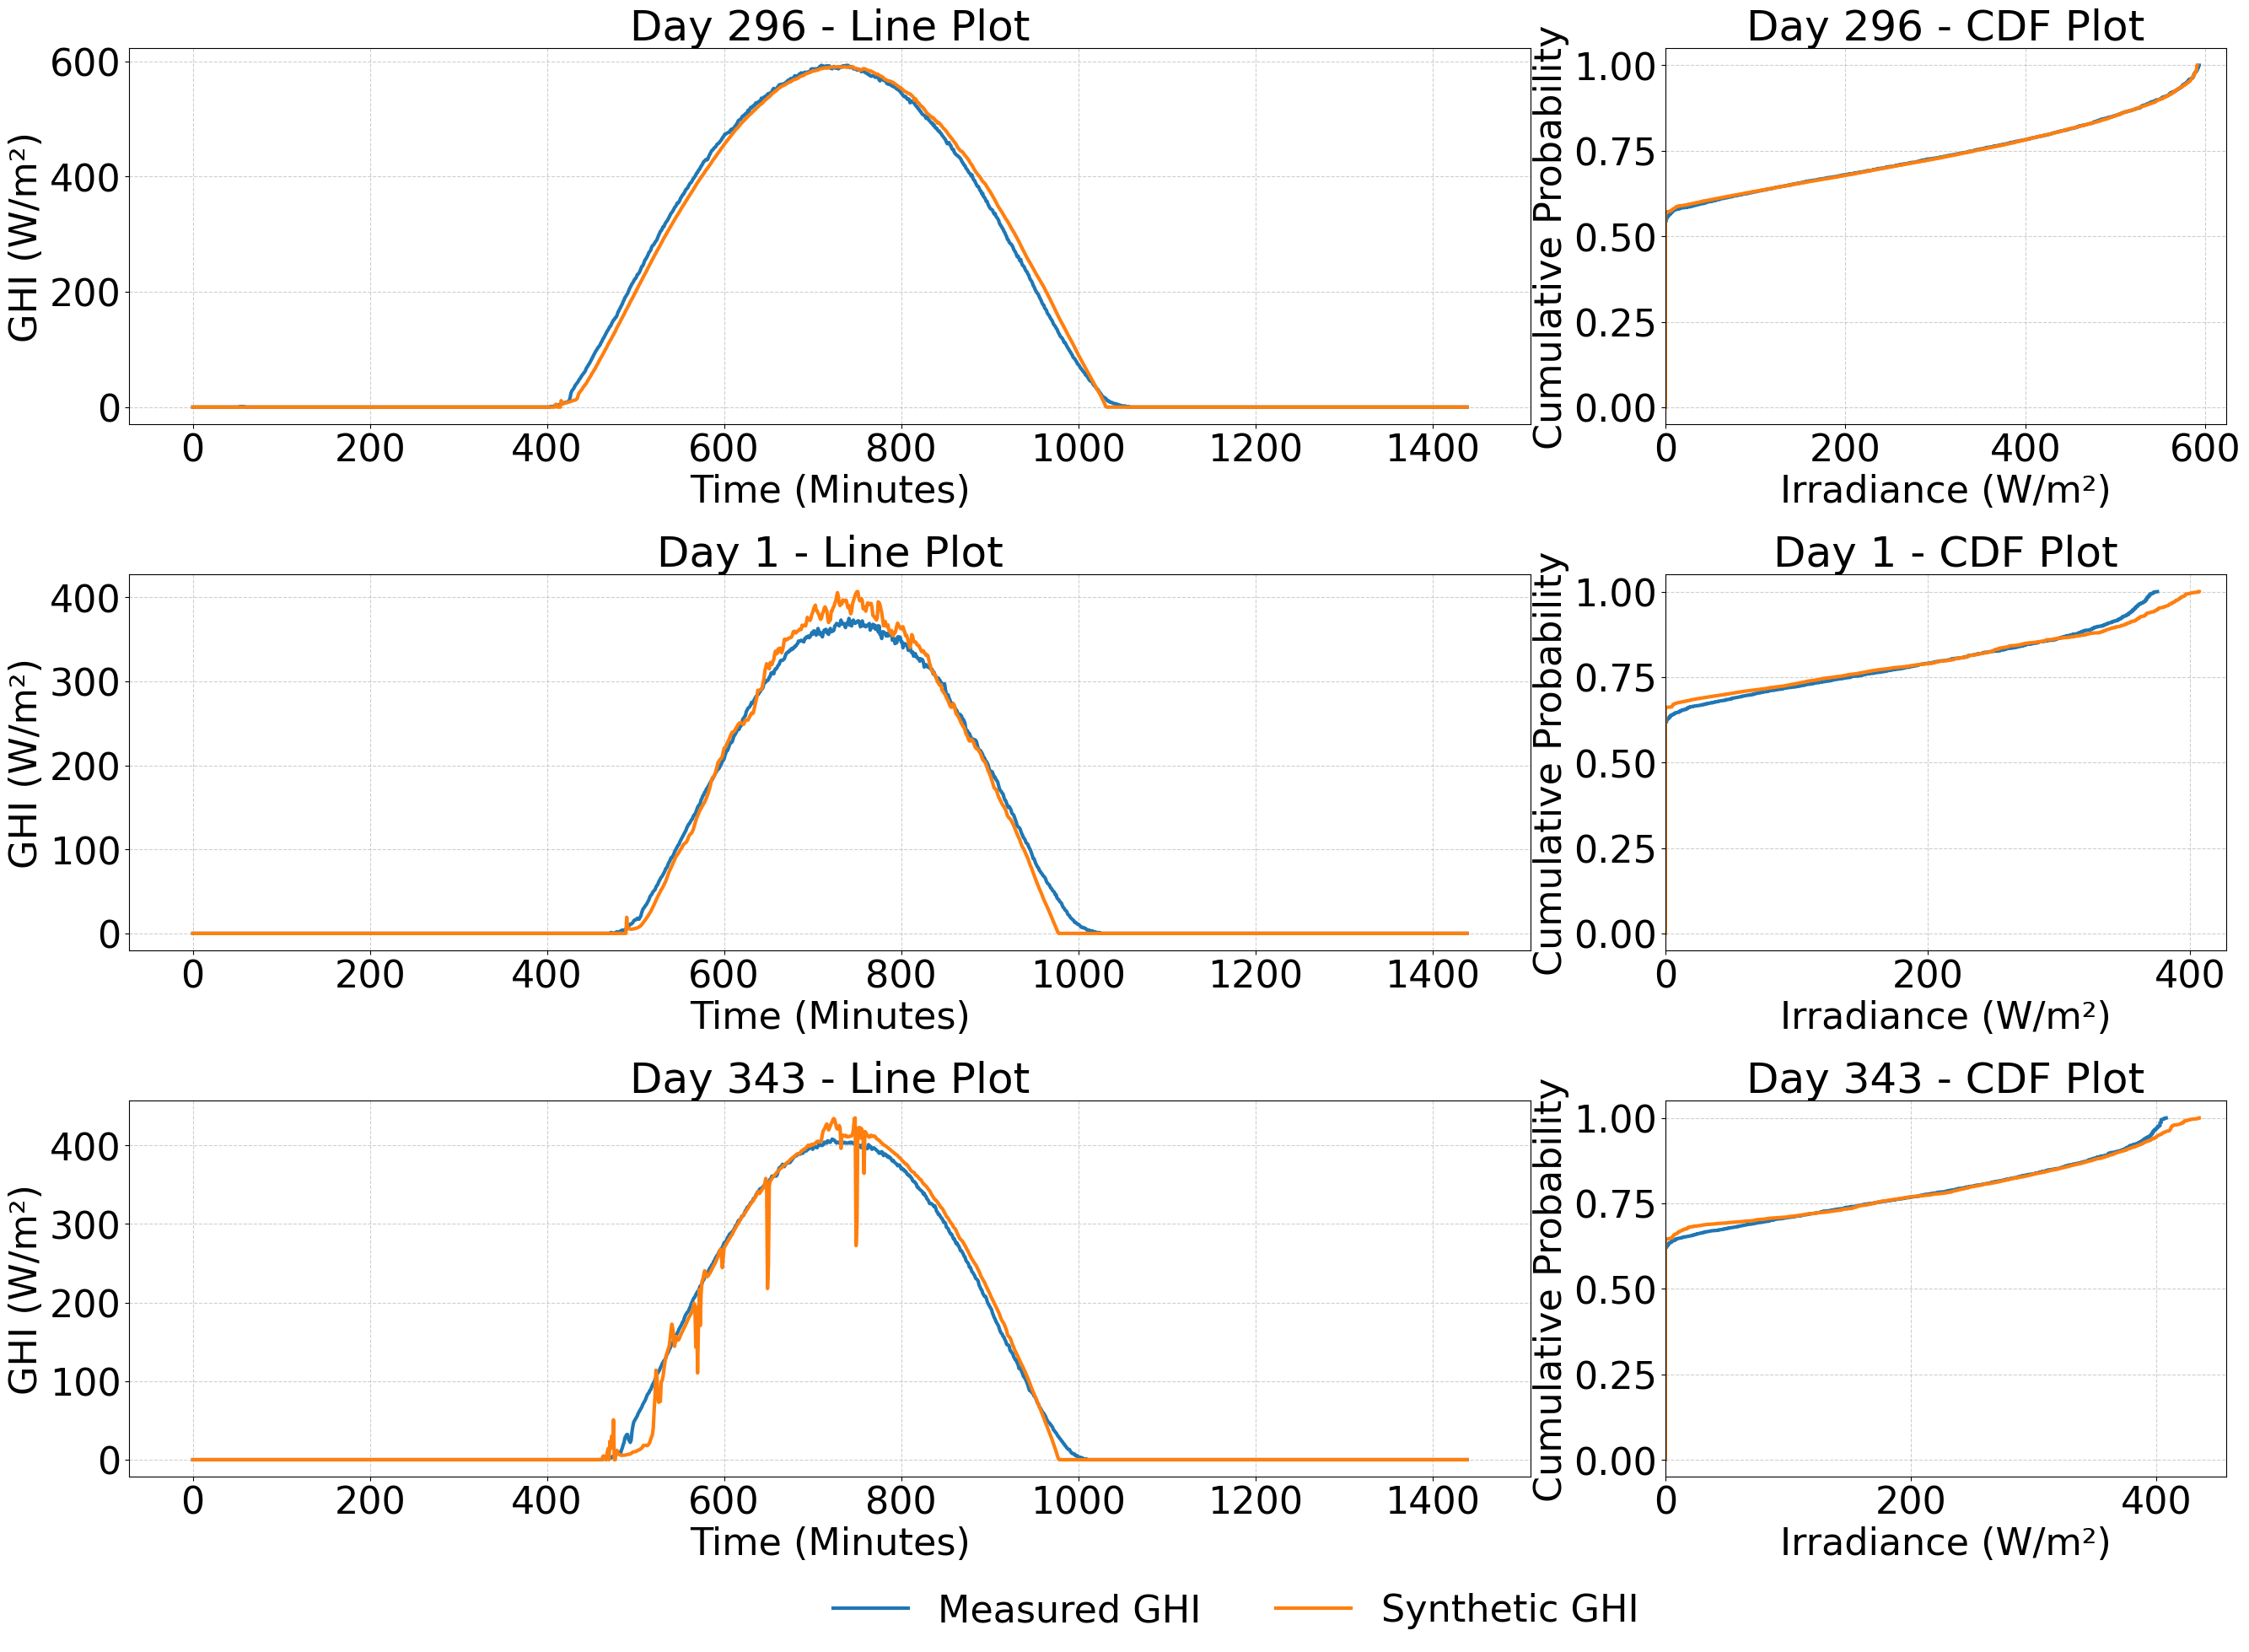

In [41]:
# Extract the GHI columns
noOfdays = 365

ghi_measured = data['ghi'].values
ghi_synthetic = df['ghi'].values

# Reshape the data into 365 days, each with 1440 minutes
ghi_measured_reshaped = ghi_measured.reshape(noOfdays, 1440)
ghi_synthetic_reshaped = ghi_synthetic.reshape(noOfdays, 1440)

# Choose three arbitrary days to plot (e.g., day 50, day 100, day 150)
days_to_plot = [295, 0, 342]

fontsize = 36
fontsize1 = 32
fontsize2 = 32
linewidth= 3
# Calculate the CDF for the GHI data
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Create the figure and grid layout
fig = plt.figure(figsize=(35, 22))
gs = GridSpec(len(days_to_plot), 3, width_ratios=[2.5, 1, 0.1], hspace=0.4)

for i, day in enumerate(days_to_plot):
    # Line plot (GHI vs Time)
    ax_line = fig.add_subplot(gs[i, 0])
    ax_line.plot(ghi_measured_reshaped[day], label='Measured GHI', linestyle='-', linewidth=linewidth)
    ax_line.plot(ghi_synthetic_reshaped[day], label='Synthetic GHI', linestyle='-', linewidth=linewidth)
    ax_line.set_title(f'Day {day + 1} - Line Plot', fontsize=fontsize)
    ax_line.set_ylabel('GHI (W/m²)', fontsize=fontsize2)
    ax_line.set_xlabel('Time (Minutes)', fontsize=fontsize2)
    ax_line.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax_line.grid(True, linestyle='--', alpha=0.6)
    #ax_line.legend(fontsize=fontsize1)

    # CDF plot (GHI vs Cumulative Probability)
    ax_cdf = fig.add_subplot(gs[i, 1])
    measured_sorted, measured_cdf = calculate_cdf(ghi_measured_reshaped[day])
    synthetic_sorted, synthetic_cdf = calculate_cdf(ghi_synthetic_reshaped[day])
    ax_cdf.plot(measured_sorted, measured_cdf, label='Measured GHI', linestyle='-', linewidth=linewidth)
    ax_cdf.plot(synthetic_sorted, synthetic_cdf, label='Synthetic GHI', linestyle='-', linewidth=linewidth)
    ax_cdf.set_title(f'Day {day + 1} - CDF Plot', fontsize=fontsize)
    ax_cdf.set_ylabel('Cumulative Probability', fontsize=fontsize2)
    ax_cdf.set_xlabel('Irradiance (W/m²)', fontsize=fontsize2)
    ax_cdf.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax_cdf.grid(True, linestyle='--', alpha=0.6)
    ax_cdf.set_xlim(0, None)  # Start x-axis from zero


# Add a single legend below the entire figure
fig.legend(
    ['Measured GHI', 'Synthetic GHI'],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.01),
    ncol=2,
    fontsize=fontsize1,
    frameon=False,
)

plt.savefig('ghi_min.png', bbox_inches='tight')

# Show plot (optional)
#plt.show()

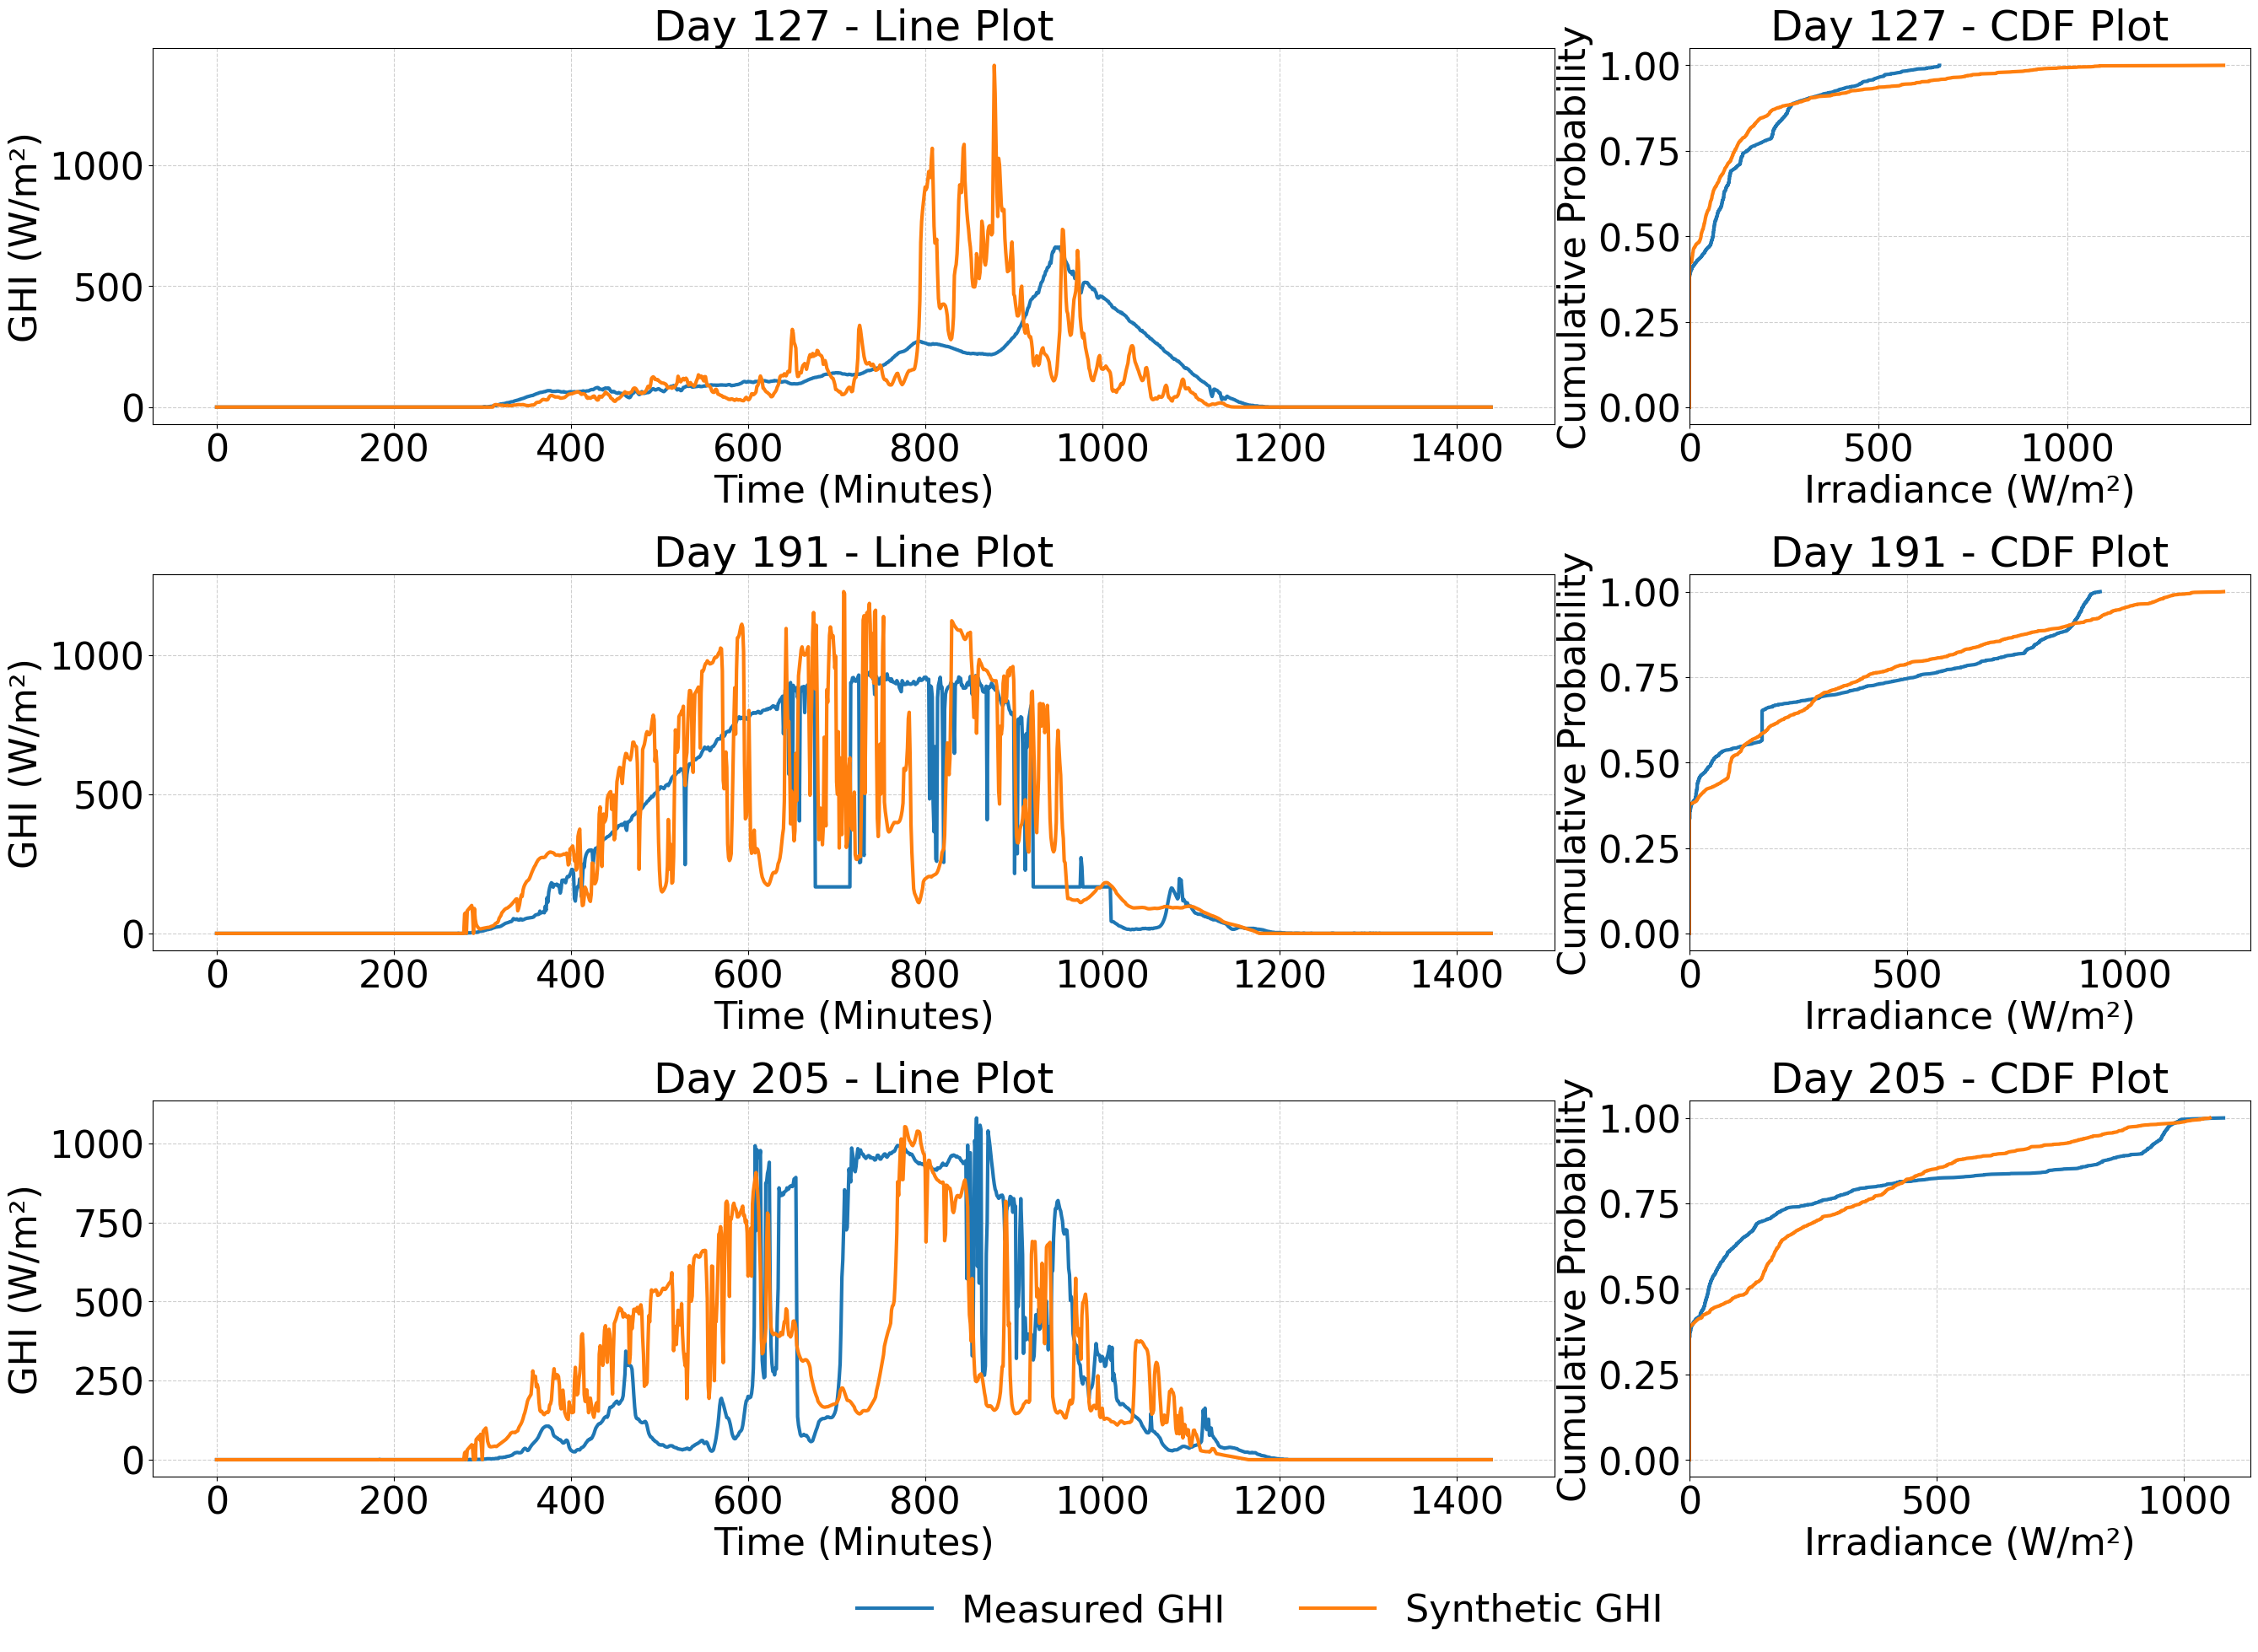

In [48]:
# Extract the GHI columns
noOfdays = 365

ghi_measured = data['ghi'].values
ghi_synthetic = df['ghi'].values

# Reshape the data into 365 days, each with 1440 minutes
ghi_measured_reshaped = ghi_measured.reshape(noOfdays, 1440)
ghi_synthetic_reshaped = ghi_synthetic.reshape(noOfdays, 1440)

# Choose three arbitrary days to plot (e.g., day 50, day 100, day 150)
days_to_plot = [126, 190, 204]

fontsize = 36
fontsize1 = 32
fontsize2 = 32
linewidth= 3
# Calculate the CDF for the GHI data
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Create the figure and grid layout
fig = plt.figure(figsize=(35, 22))
gs = GridSpec(len(days_to_plot), 3, width_ratios=[2.5, 1, 0.1], hspace=0.4)

for i, day in enumerate(days_to_plot):
    # Line plot (GHI vs Time)
    ax_line = fig.add_subplot(gs[i, 0])
    ax_line.plot(ghi_measured_reshaped[day], label='Measured GHI', linestyle='-', linewidth=linewidth)
    ax_line.plot(ghi_synthetic_reshaped[day], label='Synthetic GHI', linestyle='-', linewidth=linewidth)
    ax_line.set_title(f'Day {day + 1} - Line Plot', fontsize=fontsize)
    ax_line.set_ylabel('GHI (W/m²)', fontsize=fontsize2)
    ax_line.set_xlabel('Time (Minutes)', fontsize=fontsize2)
    ax_line.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax_line.grid(True, linestyle='--', alpha=0.6)
    #ax_line.legend(fontsize=fontsize1)

    # CDF plot (GHI vs Cumulative Probability)
    ax_cdf = fig.add_subplot(gs[i, 1])
    measured_sorted, measured_cdf = calculate_cdf(ghi_measured_reshaped[day])
    synthetic_sorted, synthetic_cdf = calculate_cdf(ghi_synthetic_reshaped[day])
    ax_cdf.plot(measured_sorted, measured_cdf, label='Measured GHI', linestyle='-', linewidth=linewidth)
    ax_cdf.plot(synthetic_sorted, synthetic_cdf, label='Synthetic GHI', linestyle='-', linewidth=linewidth)
    ax_cdf.set_title(f'Day {day + 1} - CDF Plot', fontsize=fontsize)
    ax_cdf.set_ylabel('Cumulative Probability', fontsize=fontsize2)
    ax_cdf.set_xlabel('Irradiance (W/m²)', fontsize=fontsize2)
    ax_cdf.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax_cdf.grid(True, linestyle='--', alpha=0.6)
    ax_cdf.set_xlim(0, None)  # Start x-axis from zero


# Add a single legend below the entire figure
fig.legend(
    ['Measured GHI', 'Synthetic GHI'],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.01),
    ncol=2,
    fontsize=fontsize1,
    frameon=False,
)

plt.savefig('ghi_max.png', bbox_inches='tight')

# Show plot (optional)
plt.show()

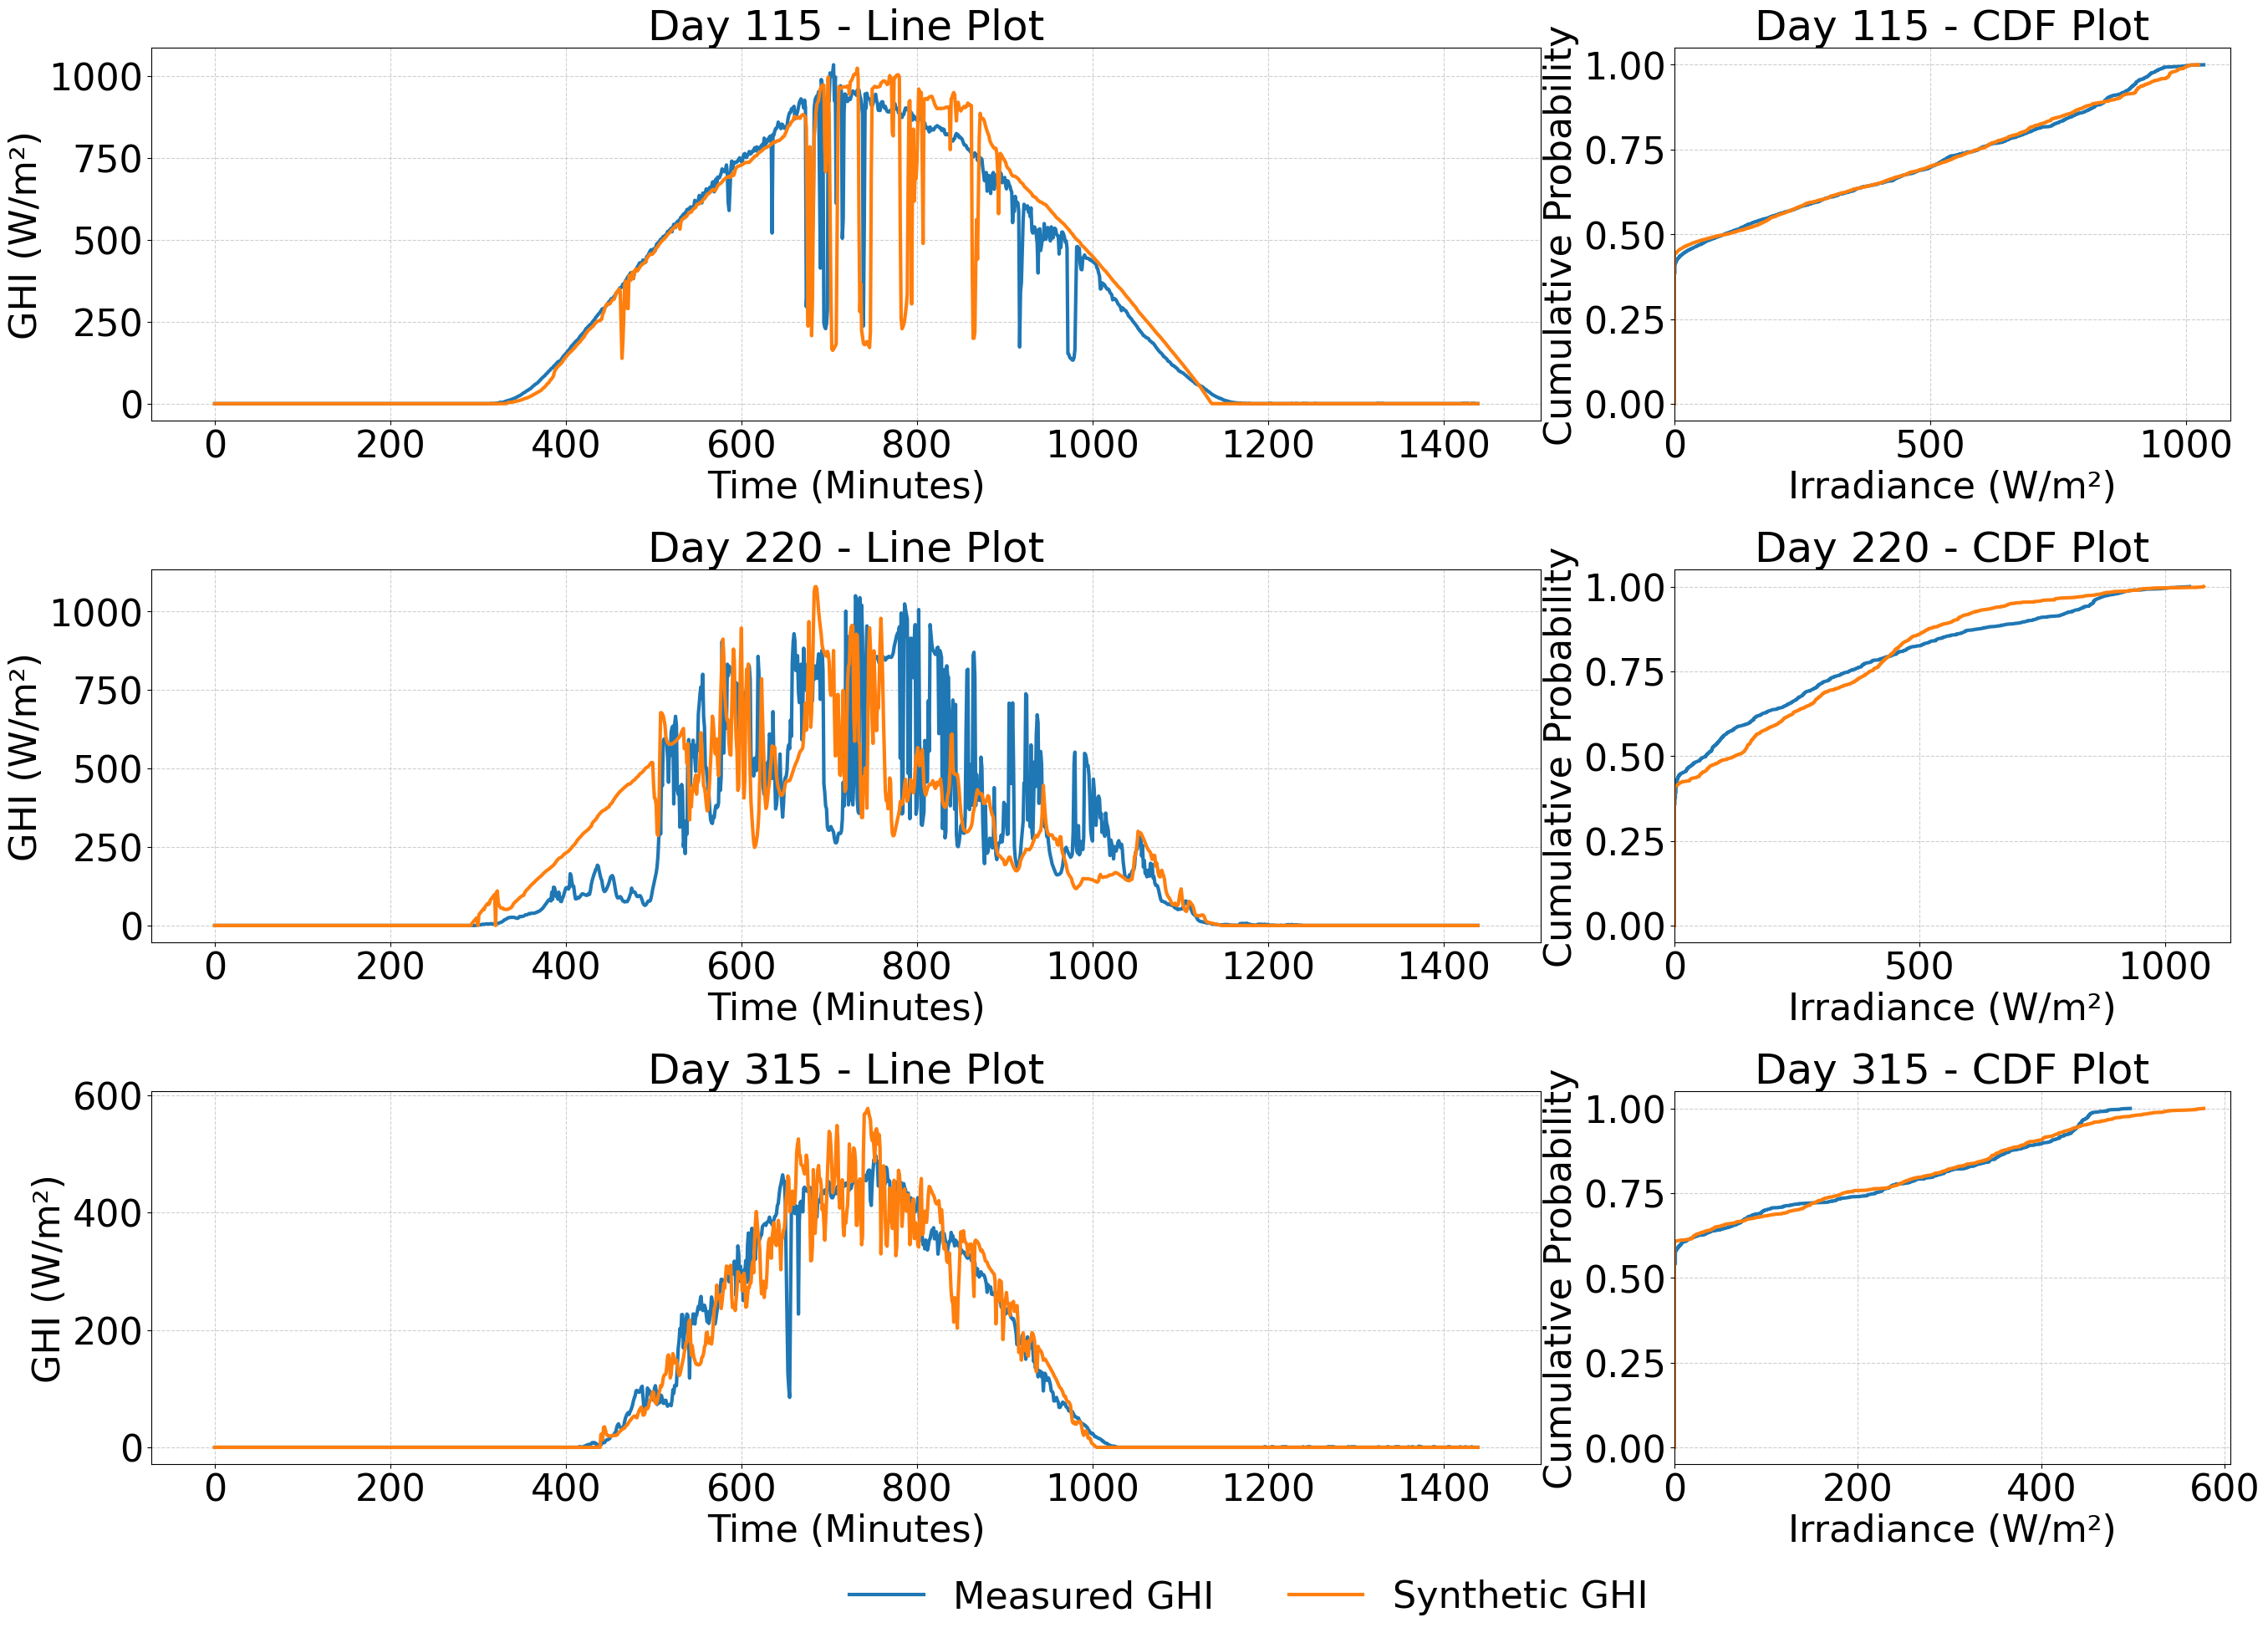

In [43]:
# Extract the GHI columns
noOfdays = 365

ghi_measured = data['ghi'].values
ghi_synthetic = df['ghi'].values

# Reshape the data into 365 days, each with 1440 minutes
ghi_measured_reshaped = ghi_measured.reshape(noOfdays, 1440)
ghi_synthetic_reshaped = ghi_synthetic.reshape(noOfdays, 1440)

# Choose three arbitrary days to plot (e.g., day 50, day 100, day 150)
days_to_plot = [114, 219, 314]

fontsize = 36
fontsize1 = 32
fontsize2 = 32
linewidth= 3
# Calculate the CDF for the GHI data
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Create the figure and grid layout
fig = plt.figure(figsize=(35, 22))
gs = GridSpec(len(days_to_plot), 3, width_ratios=[2.5, 1, 0.1], hspace=0.4)

for i, day in enumerate(days_to_plot):
    # Line plot (GHI vs Time)
    ax_line = fig.add_subplot(gs[i, 0])
    ax_line.plot(ghi_measured_reshaped[day], label='Measured GHI', linestyle='-', linewidth=linewidth)
    ax_line.plot(ghi_synthetic_reshaped[day], label='Synthetic GHI', linestyle='-', linewidth=linewidth)
    ax_line.set_title(f'Day {day + 1} - Line Plot', fontsize=fontsize)
    ax_line.set_ylabel('GHI (W/m²)', fontsize=fontsize2)
    ax_line.set_xlabel('Time (Minutes)', fontsize=fontsize2)
    ax_line.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax_line.grid(True, linestyle='--', alpha=0.6)
    #ax_line.legend(fontsize=fontsize1)

    # CDF plot (GHI vs Cumulative Probability)
    ax_cdf = fig.add_subplot(gs[i, 1])
    measured_sorted, measured_cdf = calculate_cdf(ghi_measured_reshaped[day])
    synthetic_sorted, synthetic_cdf = calculate_cdf(ghi_synthetic_reshaped[day])
    ax_cdf.plot(measured_sorted, measured_cdf, label='Measured GHI', linestyle='-', linewidth=linewidth)
    ax_cdf.plot(synthetic_sorted, synthetic_cdf, label='Synthetic GHI', linestyle='-', linewidth=linewidth)
    ax_cdf.set_title(f'Day {day + 1} - CDF Plot', fontsize=fontsize)
    ax_cdf.set_ylabel('Cumulative Probability', fontsize=fontsize2)
    ax_cdf.set_xlabel('Irradiance (W/m²)', fontsize=fontsize2)
    ax_cdf.tick_params(axis='both', which='major', labelsize=fontsize1)
    ax_cdf.grid(True, linestyle='--', alpha=0.6)
    ax_cdf.set_xlim(0, None)  # Start x-axis from zero


# Add a single legend below the entire figure
fig.legend(
    ['Measured GHI', 'Synthetic GHI'],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.01),
    ncol=2,
    fontsize=fontsize1,
    frameon=False,
)

# Adjust layout and save
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('ghi.png', bbox_inches='tight')

# Show plot (optional)
plt.show()

In [44]:
df.to_csv('df_Milan17_cluster.csv', index=False)

In [45]:
df_hourly.to_csv('df_Milan17_hr_cluster.csv', index=False)

In [46]:
daily_nrmse.to_csv('daily_nrmse.csv')

In [47]:
df_daily = df_hourly.resample('d').mean()
df_daily

,variable,ghi,GHI
date,,,
2017-01-01,0.0,79.700000,79.700000
2017-01-02,1.0,35.947917,35.947917
2017-01-03,2.0,76.677777,76.677778
2017-01-04,3.0,82.941666,82.941667
2017-01-05,4.0,91.850000,91.850000
...,...,...,...
2017-12-27,360.0,3.561111,3.561111
2017-12-28,361.0,79.084722,79.084722
2017-12-29,362.0,77.362500,77.362500
